In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv1D,Conv2D, Dense, Flatten, MaxPooling1D, MaxPooling2D, AveragePooling2D
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import calendar
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#!pip install xgboost

In [4]:
#import yfinance as yf
#sp500 = "LT.NS"
#data = yf.download(sp500, start="2019-11-25", end="2024-11-25")
#data.to_csv("data/LnT_historical_data.csv")

In [6]:
df_train_all = pd.read_csv("data/LnT_historical_data.csv")

In [7]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume
0,2019-11-25 00:00:00+00:00,1259.961792,1380.849976,1389.000000,1371.099976,1378.500000,2956576
1,2019-11-26 00:00:00+00:00,1243.674438,1363.000000,1380.000000,1359.550049,1379.349976,4853977
2,2019-11-27 00:00:00+00:00,1218.582153,1335.500000,1370.000000,1314.150024,1365.000000,7904745
3,2019-11-28 00:00:00+00:00,1231.721558,1349.900024,1354.000000,1327.199951,1344.000000,4503913
4,2019-11-29 00:00:00+00:00,1214.065308,1330.550049,1350.199951,1328.000000,1350.000000,2515083
...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581


In [8]:
df_train_all["Date"] = pd.to_datetime(df_train_all["Date"])

In [9]:
df_train_all.describe()

,Adj_Close,Close,High,Low,Open,Volume
count,1238.000000,1238.000000,1238.000000,1238.000000,1238.000000,1.238000e+03
mean,2008.925211,2062.823021,2085.688566,2040.985463,2063.858482,3.011686e+06
std,916.109006,894.685372,901.813680,886.812497,894.810542,2.204713e+06
min,654.971985,707.900024,755.750000,661.000000,697.200012,2.127960e+05
25%,1305.126495,1373.475006,1392.787476,1356.712494,1377.149963,1.666719e+06
50%,1791.520264,1850.674988,1871.500000,1827.625000,1849.450012,2.289248e+06
75%,2637.318298,2665.549927,2688.162476,2645.337463,2668.712463,3.616259e+06
max,3866.753906,3897.149902,3919.899902,3801.100098,3855.399902,2.115335e+07


In [10]:
df_train_all.isnull().sum()

Date         0
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [11]:
type(df_train_all["Date"])

pandas.core.series.Series

In [12]:
df_train_all["epoch_time"]= df_train_all["Date"].apply(lambda x: x.timestamp())

In [13]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time
0,2019-11-25 00:00:00+00:00,1259.961792,1380.849976,1389.000000,1371.099976,1378.500000,2956576,1.574640e+09
1,2019-11-26 00:00:00+00:00,1243.674438,1363.000000,1380.000000,1359.550049,1379.349976,4853977,1.574726e+09
2,2019-11-27 00:00:00+00:00,1218.582153,1335.500000,1370.000000,1314.150024,1365.000000,7904745,1.574813e+09
3,2019-11-28 00:00:00+00:00,1231.721558,1349.900024,1354.000000,1327.199951,1344.000000,4503913,1.574899e+09
4,2019-11-29 00:00:00+00:00,1214.065308,1330.550049,1350.199951,1328.000000,1350.000000,2515083,1.574986e+09
...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765,1.731542e+09
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217,1.731888e+09
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460,1.731974e+09
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581,1.732147e+09


In [14]:
def is_last_thursday(date):
    year = date.year
    month = date.month
    
    last_day = calendar.monthrange(year, month)[1]
    last_date = datetime(year, month, last_day)
    last_day_weekday = last_date.weekday()
    days_since_last_thursday = (last_day_weekday - calendar.THURSDAY) % 7
    last_thursday_date = last_date - timedelta(days=days_since_last_thursday)
    
    return 1 if date.date() == last_thursday_date.date() else 0

In [15]:
df_train_all['opt_expiry'] = df_train_all['Date'].apply(is_last_thursday)

In [16]:
df_train_all['10DaysMA'] =  df_train_all['Adj_Close'].rolling(window=10).mean()
df_train_all['30DaysMA'] =  df_train_all['Adj_Close'].rolling(window=30).mean()
df_train_all['50DaysMA'] =  df_train_all['Adj_Close'].rolling(window=50).mean()

In [17]:
df_train_all

,Date,Adj_Close,Close,High,Low,Open,Volume,epoch_time,opt_expiry,10DaysMA,30DaysMA,50DaysMA
0,2019-11-25 00:00:00+00:00,1259.961792,1380.849976,1389.000000,1371.099976,1378.500000,2956576,1.574640e+09,0,NaN,NaN,NaN
1,2019-11-26 00:00:00+00:00,1243.674438,1363.000000,1380.000000,1359.550049,1379.349976,4853977,1.574726e+09,0,NaN,NaN,NaN
2,2019-11-27 00:00:00+00:00,1218.582153,1335.500000,1370.000000,1314.150024,1365.000000,7904745,1.574813e+09,0,NaN,NaN,NaN
3,2019-11-28 00:00:00+00:00,1231.721558,1349.900024,1354.000000,1327.199951,1344.000000,4503913,1.574899e+09,1,NaN,NaN,NaN
4,2019-11-29 00:00:00+00:00,1214.065308,1330.550049,1350.199951,1328.000000,1350.000000,2515083,1.574986e+09,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,3526.250000,3526.250000,3565.750000,3500.149902,3558.000000,1291765,1.731542e+09,0,3602.230029,3526.965015,3583.747998
1234,2024-11-18 00:00:00+00:00,3542.149902,3542.149902,3568.300049,3510.850098,3521.100098,1233217,1.731888e+09,0,3593.810010,3528.571680,3582.107998
1235,2024-11-19 00:00:00+00:00,3505.899902,3505.899902,3607.000000,3495.000000,3559.899902,1826460,1.731974e+09,0,3586.955005,3529.823340,3580.730996
1236,2024-11-21 00:00:00+00:00,3483.500000,3483.500000,3530.550049,3452.449951,3530.000000,1510581,1.732147e+09,0,3577.825000,3528.193343,3578.834995


In [18]:
#df_train_all["Next_Close"] = df_train_all.shift(-1)["Close"]

In [19]:
df_train_all.dropna(subset=['50DaysMA'], inplace=True)
#df_train_all.dropna(subset=['Next_Close'], inplace=True)

In [20]:
df_train_all.isnull().sum()

Date          0
Adj_Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
epoch_time    0
opt_expiry    0
10DaysMA      0
30DaysMA      0
50DaysMA      0
dtype: int64

In [21]:
df_train_all.columns

Index(['Date', 'Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'epoch_time', 'opt_expiry', '10DaysMA', '30DaysMA', '50DaysMA'],
      dtype='object')

In [215]:
features_to_scale = ['Open', 'Volume', 'High','Low', 'Adj_Close','10DaysMA','30DaysMA','50DaysMA']
features_to_leave = ['epoch_time','opt_expiry']
target = ['Close']
df_train_all_scaled = df_train_all.copy()
df_train_all_scaled
feature_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))
df_train_all_scaled[features_to_scale] = pd.DataFrame(
    feature_scaler.fit_transform(df_train_all[features_to_scale]),
    columns=features_to_scale,
    index=df_train_all.index
)

df_train_all_scaled["Scaled_Close"] = pd.DataFrame(
    target_scaler.fit_transform(df_train_all[["Close"]]),
    columns=["Scaled_Close"],
    index=df_train_all.index
)
df_train_all_scaled.drop(columns=["Close"],inplace=True)
df_train_all_scaled.drop(columns=["opt_expiry"], inplace=True)

In [264]:
## Trial 2
features_to_use = ['Open', 'Volume', 'High','Low', 'Adj_Close']
features_to_scale = ['Open', 'Volume', 'High','Low', 'Adj_Close','epoch_time']
features_to_leave = ['epoch_time']
target = ['Close']
df_train_all_scaled = df_train_all.copy()
df_train_all_scaled
feature_scaler = MinMaxScaler(feature_range=(0,1))
target_scaler = MinMaxScaler(feature_range=(0,1))
df_train_all_scaled[features_to_scale] = pd.DataFrame(
    feature_scaler.fit_transform(df_train_all[features_to_scale]),
    columns=features_to_scale,
    index=df_train_all.index
)

df_train_all_scaled["Scaled_Close"] = pd.DataFrame(
    target_scaler.fit_transform(df_train_all[["Close"]]),
    columns=["Scaled_Close"],
    index=df_train_all.index
)
df_train_all_scaled.drop(columns=["Close"],inplace=True)
df_train_all_scaled.drop(columns=["opt_expiry", '10DaysMA','30DaysMA','50DaysMA'], inplace=True)
df_train_all_scaled

,Date,Adj_Close,High,Low,Open,Volume,epoch_time,Scaled_Close
49,2020-02-03 00:00:00+00:00,0.161604,0.173238,0.194580,0.187702,0.265254,0.000000,0.181469
50,2020-02-04 00:00:00+00:00,0.163053,0.174312,0.199532,0.189602,0.161959,0.000570,0.183068
51,2020-02-05 00:00:00+00:00,0.168252,0.179906,0.201904,0.190203,0.191366,0.001140,0.188806
52,2020-02-06 00:00:00+00:00,0.170397,0.179906,0.206379,0.198119,0.102273,0.001710,0.191173
53,2020-02-07 00:00:00+00:00,0.165113,0.176556,0.202223,0.195000,0.135670,0.002281,0.185341
...,...,...,...,...,...,...,...,...
1233,2024-11-14 00:00:00+00:00,0.893983,0.888074,0.904159,0.905832,0.051525,0.995439,0.883703
1234,2024-11-18 00:00:00+00:00,0.898933,0.888880,0.907567,0.894149,0.048729,0.997719,0.888689
1235,2024-11-19 00:00:00+00:00,0.887647,0.901111,0.902519,0.906434,0.077059,0.998290,0.877322
1236,2024-11-21 00:00:00+00:00,0.880673,0.876950,0.888968,0.896967,0.061975,0.999430,0.870299


In [265]:
df_train = df_train_all_scaled[df_train_all_scaled["Date"] <= "2023-12-31"]

In [266]:
df_val = df_train_all_scaled[df_train_all_scaled["Date"].between("2024-01-01","2024-05-31")]

In [267]:
df_test = df_train_all_scaled[df_train_all_scaled["Date"] >= "2024-05-31"]

In [268]:
df_train.drop(columns=["Date"], inplace = True)
df_val.drop(columns=["Date"], inplace = True)
df_test.drop(columns=["Date"], inplace = True)

C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_72392\1681249928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["Date"], inplace = True)
C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_72392\1681249928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["Date"], inplace = True)
C:\Users\Divay Nagpal\AppData\Local\Temp\ipykernel_72392\1681249928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [269]:
timesteps = 20
features_len = len(df_train.columns) - 1 # removing Scaled ccose

class EnhancedTime2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Time2Vec layer that includes both sine and cosine periodicity along with a linear term.
        
        Args:
        - input_dim (int): Number of input features (time steps).
        - output_dim (int): Number of output dimensions for encoding.
        """
        super(EnhancedTime2Vec, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)  # Linear term
        self.sin_periodic = nn.Linear(input_dim, (output_dim - 1) // 2, bias=True)  # Sine terms
        self.cos_periodic = nn.Linear(input_dim, (output_dim - 1) // 2, bias=True)  # Cosine terms

    def forward(self, x):
        """
        Forward pass to calculate Time2Vec encoding.

        Args:
        - x (Tensor): Input tensor of shape (Batch Size, Input Dim).

        Returns:
        - Tensor: Output tensor of shape (Batch Size, Output Dim).
        """
        linear_part = self.linear(x)  # Linear component
        sin_part = torch.sin(self.sin_periodic(x))  # Sine periodicity
        cos_part = torch.cos(self.cos_periodic(x))  # Cosine periodicity
        return torch.cat([linear_part, sin_part, cos_part], dim=-1)

In [270]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='w0')
        self.b0 = self.add_weight(shape=(1,), initializer='uniform', trainable=True, name='b0')
        self.w = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='w')
        self.b = self.add_weight(shape=(self.kernel_size, 1), initializer='uniform', trainable=True, name='b')

    def call(self, inputs):
        linear_term = self.w0 * inputs + self.b0
        periodic_term = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([linear_term, periodic_term], axis=-1)

In [276]:
def create_sequences_with_time2vec(data, timesteps, features, time2vec):
    sequences = []
    targets = []

    for i in range(len(data) - timesteps):
        # Extract sequence features and target
        seq = data.iloc[i:i + timesteps, features].values
        epoch_times = data.iloc[i:i + timesteps]['epoch_time'].values.reshape(-1, 1)  # Shape (timesteps, 1)

        # Apply Time2Vec on epoch times
        time2vec_features = time2vec(tf.convert_to_tensor(epoch_times, dtype=tf.float32)).numpy()
        #print("time2vec_features : ",time2vec_features)
        # Concatenate Time2Vec features with other sequence features
        enhanced_seq = np.concatenate([seq, time2vec_features], axis=-1)

        # Append enhanced sequence and target
        sequences.append(enhanced_seq)
        targets.append(data.iloc[i + timesteps]['Scaled_Close'])

    return np.array(sequences), np.array(targets)

In [277]:
df_train.columns
feature_indexes = np.where(np.isin(df_train.columns, features_to_use))[0]
feature_indexes

array([0, 1, 2, 3, 4], dtype=int64)

In [278]:

time2vec_layer = Time2Vec(kernel_size=1)  # Example kernel size

In [279]:
df_test.columns
df_train_scaled=df_train.copy()
df_val_scaled=df_val.copy()
df_test_scaled=df_test.copy()

In [280]:
sequences, targets = create_sequences_with_time2vec(df_train_scaled, timesteps, feature_indexes, time2vec_layer)
sequences_val, targets_val = create_sequences_with_time2vec(df_val_scaled, timesteps, feature_indexes, time2vec_layer)
sequences_test, targets_test = create_sequences_with_time2vec(df_test_scaled, timesteps, feature_indexes, time2vec_layer)

In [281]:
print("Sequence shape:", sequences.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets shape:", targets.shape) 
print("Sequence val shape:", sequences_val.shape)  # Expected: (num_sequences, timesteps, original_features + Time2Vec features)
print("Targets val shape:", targets_val.shape) 

Sequence shape: (949, 20, 7)
Targets shape: (949,)
Sequence val shape: (81, 20, 7)
Targets val shape: (81,)


In [282]:
sequences[0][0]

array([ 0.16160396,  0.17323769,  0.19457978,  0.18770186,  0.26525363,
       -0.02896122,  0.01946923])

In [283]:
class PositionalEncoding(Layer):
    def __init__(self, maxlen, dim):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.dim = dim

    def call(self, inputs):
        # Get the shape of the inputs to determine the sequence length
        seq_len = tf.shape(inputs)[1]  # Sequence length (50 in your case)
        
        # Generate positional encodings for the sequence length
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (seq_len, 1)
        div_term = tf.exp(tf.range(0, self.dim, 2, dtype=tf.float32) * -(np.log(10000.0) / self.dim))  # Shape (dim/2,)
        
        # Apply sine to even indices and cosine to odd indices
        pos_enc = tf.zeros((seq_len, self.dim), dtype=tf.float32)
        print(type(pos_enc))
        numpy_array = tensor_util.MakeNdarray(pos_enc)
        print(numpy_array)
        #concrete_tensor = tf.convert_to_tensor(pos_enc)
        #print(type(concrete_tensor))
        #pos_enc = concrete_tensor.numpy()
        pos_enc = pos_enc.numpy()  # convert Tensor to NumPy array before modifying
        
        pos_enc[:, 0::2] = np.sin(position * div_term)  # Apply sin to even indices
        pos_enc[:, 1::2] = np.cos(position * div_term)  # Apply cos to odd indices
        
        # Convert back to a Tensor
        pos_enc = tf.convert_to_tensor(pos_enc, dtype=tf.float32)

        # Add positional encoding to the input tensor
        return inputs + pos_enc[:seq_len, :]

class PositionalEncoding(Layer):
    def __init__(self, maxlen, dim):
        super(PositionalEncoding, self).__init__()
        self.maxlen = maxlen
        self.dim = dim

    def call(self, inputs):
        print("inp:", inputs.shape)
        seq_len = tf.shape(inputs)[1]
        print("seq_len:",seq_len)
        position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.dim, 2, dtype=tf.float32) * -(np.log(10000.0) / self.dim))

        # Compute positional encodings
        pos_enc_even = tf.sin(position * div_term)  # Apply sin to even indices
        pos_enc_odd = tf.cos(position * div_term)  # Apply cos to odd indices

        # Concatenate along the last dimension
        pos_enc = tf.concat([pos_enc_even, pos_enc_odd], axis=-1)
        input_dim = tf.shape(inputs)[-1]
        pos_enc_dim = tf.shape(pos_enc)[-1]
        #print("pos : ",pos_enc.shape)
        # Ensure the shape matches the inputs
        #pos_enc = tf.pad(pos_enc, [[0, 0], [0, tf.shape(inputs)[-1] - tf.shape(pos_enc)[-1]]])
        #pos_enc = pos_enc[:, :input_dim] if pos_enc_dim > input_dim else tf.pad(pos_enc, [[0, 0], [0, input_dim - pos_enc_dim]])

        #return inputs + pos_enc
        pos_enc = tf.cond(
        pos_enc_dim > input_dim,
        lambda: pos_enc[:, :input_dim],  # Truncate if pos_enc is larger
        lambda: tf.pad(pos_enc, [[0, 0], [0, input_dim - pos_enc_dim]])  # Pad if pos_enc is smaller
        )

        return inputs + pos_enc

class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1, maxlen=20):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.positional_encoding = PositionalEncoding(maxlen=maxlen, dim=key_dim)

        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        print(f"Input shape before attention: {inputs.shape}")
        inputs = self.positional_encoding(inputs)
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        print(f"Attention output shape: {attn_output.shape}")
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2

def create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate,  maxlen=20):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Transformer Encoder Layers
    transformer_output = input_layer
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
            num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate, maxlen=maxlen)
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dense_2 = Dense(dense_units, activation="relu")(dense_2)
    dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    output_layer = Dense(1, activation="linear")(dropout_2)
    #output_layer = Dense(1, activation="linear")(dense_2)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [290]:
input_shape = (20, 7)  # Update this based on your dataset
transformer_layers = 3
time2vec_dim = 2
dense_units = 512
dropout_rate = 0.2
num_heads = 4
key_dim = 7
ff_dim = 128

model = create_transformer_model(input_shape, transformer_layers, num_heads, key_dim, ff_dim, dense_units, dropout_rate, 20)

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',          # The metric to monitor (could also be 'val_accuracy')
    patience=10,                 # Number of epochs with no improvement to wait before stopping
    verbose=0,                   # To print messages when stopping early
    restore_best_weights=True    # Restore the best weights once training is stopped
)
#, callbacks=[early_stopping]
history = model.fit(sequences,targets , validation_data=(sequences_val, targets_val), epochs=10, batch_size=None, callbacks=[early_stopping])

# Prediction
predictions = model.predict(sequences_test)

Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_38_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_38_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_39_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_39_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("positional_encoding_40_1/strided_slice:0", shape=(), dtype=int32)
Attention output shape: (None, 20, 7)
Input shape before attention: (None, 20, 7)
inp: (None, 20, 7)
seq_len: Tensor("

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 20, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_38          │ (None, 20, 7)          │         2,830 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_39          │ (None, 20, 7)          │         2,830 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_40          │ (None, 20, 7)          │         2,830 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 7)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 512)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,411 (2.05 MB)

 Trainable params: 538,411 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


C:\Users\Divay Nagpal\anaconda3\envs\python310clone\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, shape=(), dtype=int32)
 1/30 ━━━━━━━━━━━━━━━━━━━━ 20s 712ms/step - loss: 0.0977 - mae: 0.2443Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, shape=(), dtype=int32)
Attention output shape: (32, 20, 7)
Input shape before attention: (32, 20, 7)
inp: (32, 20, 7)
seq_len: tf.Tensor(20, sh

In [292]:
target_scaler.inverse_transform(targets_test.reshape(-1,1))

array([[3526.55004883],
       [3626.5       ],
       [3614.35009766],
       [3573.30004883],
       [3627.14990234],
       [3632.        ],
       [3666.10009766],
       [3650.05004883],
       [3621.10009766],
       [3649.35009766],
       [3651.60009766],
       [3636.55004883],
       [3656.19995117],
       [3618.5       ],
       [3651.44995117],
       [3538.05004883],
       [3519.44995117],
       [3619.14990234],
       [3679.89990234],
       [3774.94995117],
       [3784.64990234],
       [3815.        ],
       [3779.30004883],
       [3665.69995117],
       [3528.        ],
       [3576.19995117],
       [3638.25      ],
       [3553.55004883],
       [3592.05004883],
       [3571.94995117],
       [3551.80004883],
       [3545.19995117],
       [3568.35009766],
       [3555.05004883],
       [3572.69995117],
       [3596.05004883],
       [3606.5       ],
       [3598.55004883],
       [3641.89990234],
       [3702.69995117],
       [3689.05004883],
       [3683.449

In [288]:
targets_test

array([0.88379717, 0.91513682, 0.91132717, 0.89845579, 0.91534059,
       0.91686136, 0.92755356, 0.92252101, 0.91344366, 0.92230154,
       0.92300703, 0.91828804, 0.92444933, 0.91262839, 0.92295996,
       0.88740304, 0.88157091, 0.91283217, 0.93188053, 0.9616838 ,
       0.96472525, 0.97424162, 0.96304778, 0.92742809, 0.88425181,
       0.89936507, 0.91882107, 0.89226311, 0.90433492, 0.89803246,
       0.89171439, 0.88964491, 0.89690372, 0.89273344, 0.89826763,
       0.90558913, 0.90886575, 0.90637301, 0.91996551, 0.93902957,
       0.93474959, 0.93299366, 0.93964098, 0.93288397, 0.93509446,
       0.92275618, 0.91439993, 0.89891043, 0.90002356, 0.90562044,
       0.8870581 , 0.91372582, 0.91090384, 0.92634635, 0.93667792,
       0.94773067, 0.93307205, 0.96762562, 0.9656816 , 0.9669045 ,
       0.96761   , 0.9576703 , 0.93995453, 0.93051662, 0.92360276,
       0.87473543, 0.8735753 , 0.86554838, 0.88563141, 0.87142751,
       0.86303996, 0.87000082, 0.89273344, 0.8917457 , 0.88569

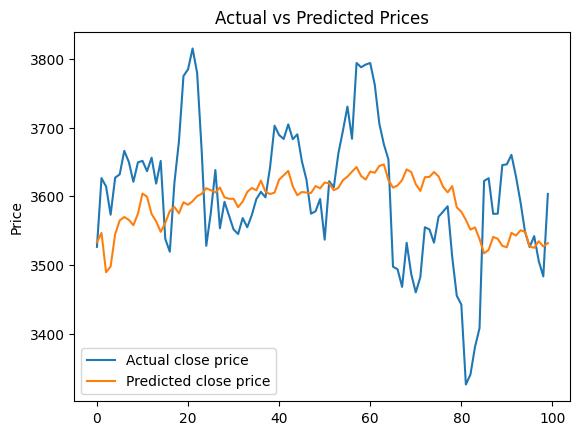

In [293]:
plt.plot(target_scaler.inverse_transform(targets_test.reshape(-1,1)), label='Actual close price')
plt.plot(target_scaler.inverse_transform(predictions.reshape(-1,1)), label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

# Appendix

In [319]:
model = create_transformer_model(sequences,input_shape, time2vec_dim, transformer_layers, dense_units, dropout_rate)
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Summary
model.summary()

Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)
Input shape before attention: (958, 10, 12)
Attention output shape: (958, 10, 12)


NameError: name 'input_layer' is not defined

In [265]:
input_columns = ['Adj_Close', 'Close', 'High', 'Low', 'Open', 'Volume', 
                 'opt_expiry', '10DaysMA', '30DaysMA', '50DaysMA']
time_column = 'epoch_time'
target_column = 'Next_Close'

In [267]:
epoch_times = df_train_scaled[time_column].values.reshape(-1, 1)  # Reshape epoch_time to (num_samples, 1)
features = df_train_scaled[input_columns].values  # Other input features
targets = df_train_scaled[target_column].values.reshape(-1, 1)  # Target variable

In [274]:
time_input = Input(shape=(1,), name="epoch_time")
other_inputs = Input(shape=(len(input_columns),), name="other_features")

In [275]:
time2vec = Time2Vec(kernel_size=1)(time_input)

In [276]:
concat_inputs = Concatenate()([time2vec, other_inputs])

In [278]:
# Transformer-like Dense Layers
dense1 = Dense(64, activation='relu')(concat_inputs)
dense2 = Dense(32, activation='relu')(dense1)
# Output layer
output = Dense(1, name='Next_Close')(dense2)

In [279]:
model = tf.keras.Model(inputs=[time_input, other_inputs], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [280]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ epoch_time          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_19        │ (None, 2)         │          4 │ epoch_time[0][0]  │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_17      │ (None, 12)        │          0 │ time2_vec_19[0][… │
│ (Concatenate)       │                   │            │ other_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 64)        │        832 │ concatenate_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 32)        │      2,080 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Next_Close (Dense)  │ (None, 1)         │         33 │ dense_39[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,949 (11.52 KB)

 Trainable params: 2,949 (11.52 KB)

 Non-trainable params: 0 (0.00 B)

In [304]:
history = model.fit(
    {'epoch_time': epoch_times, 'other_features': features}, 
    targets, 
    epochs=100, 
    batch_size=None
)

ValueError: Unrecognized data type: x={'epoch_time': array([[1.5807744e+09],
       [1.5808608e+09],
       [1.5809472e+09],
       [1.5810336e+09],
       [1.5812928e+09],
       [1.5813792e+09],
       [1.5814656e+09],
       [1.5815520e+09],
       [1.5816384e+09],
       [1.5818976e+09],
       [1.5819840e+09],
       [1.5820704e+09],
       [1.5821568e+09],
       [1.5825024e+09],
       [1.5825888e+09],
       [1.5826752e+09],
       [1.5827616e+09],
       [1.5828480e+09],
       [1.5831072e+09],
       [1.5831936e+09],
       [1.5832800e+09],
       [1.5833664e+09],
       [1.5834528e+09],
       [1.5837120e+09],
       [1.5838848e+09],
       [1.5839712e+09],
       [1.5840576e+09],
       [1.5843168e+09],
       [1.5844032e+09],
       [1.5844896e+09],
       [1.5845760e+09],
       [1.5846624e+09],
       [1.5849216e+09],
       [1.5850080e+09],
       [1.5850944e+09],
       [1.5851808e+09],
       [1.5852672e+09],
       [1.5855264e+09],
       [1.5856128e+09],
       [1.5856992e+09],
       [1.5858720e+09],
       [1.5862176e+09],
       [1.5863040e+09],
       [1.5863904e+09],
       [1.5867360e+09],
       [1.5869088e+09],
       [1.5869952e+09],
       [1.5870816e+09],
       [1.5873408e+09],
       [1.5874272e+09],
       [1.5875136e+09],
       [1.5876000e+09],
       [1.5876864e+09],
       [1.5879456e+09],
       [1.5880320e+09],
       [1.5881184e+09],
       [1.5882048e+09],
       [1.5885504e+09],
       [1.5886368e+09],
       [1.5887232e+09],
       [1.5888096e+09],
       [1.5888960e+09],
       [1.5891552e+09],
       [1.5892416e+09],
       [1.5893280e+09],
       [1.5894144e+09],
       [1.5895008e+09],
       [1.5897600e+09],
       [1.5898464e+09],
       [1.5899328e+09],
       [1.5900192e+09],
       [1.5901056e+09],
       [1.5904512e+09],
       [1.5905376e+09],
       [1.5906240e+09],
       [1.5907104e+09],
       [1.5909696e+09],
       [1.5910560e+09],
       [1.5911424e+09],
       [1.5912288e+09],
       [1.5913152e+09],
       [1.5915744e+09],
       [1.5916608e+09],
       [1.5917472e+09],
       [1.5918336e+09],
       [1.5919200e+09],
       [1.5921792e+09],
       [1.5922656e+09],
       [1.5923520e+09],
       [1.5924384e+09],
       [1.5925248e+09],
       [1.5927840e+09],
       [1.5928704e+09],
       [1.5929568e+09],
       [1.5930432e+09],
       [1.5931296e+09],
       [1.5933888e+09],
       [1.5934752e+09],
       [1.5935616e+09],
       [1.5936480e+09],
       [1.5937344e+09],
       [1.5939936e+09],
       [1.5940800e+09],
       [1.5941664e+09],
       [1.5942528e+09],
       [1.5943392e+09],
       [1.5945984e+09],
       [1.5946848e+09],
       [1.5947712e+09],
       [1.5948576e+09],
       [1.5949440e+09],
       [1.5952032e+09],
       [1.5952896e+09],
       [1.5953760e+09],
       [1.5954624e+09],
       [1.5955488e+09],
       [1.5958080e+09],
       [1.5958944e+09],
       [1.5959808e+09],
       [1.5960672e+09],
       [1.5961536e+09],
       [1.5964128e+09],
       [1.5964992e+09],
       [1.5965856e+09],
       [1.5966720e+09],
       [1.5967584e+09],
       [1.5970176e+09],
       [1.5971040e+09],
       [1.5971904e+09],
       [1.5972768e+09],
       [1.5973632e+09],
       [1.5976224e+09],
       [1.5977088e+09],
       [1.5977952e+09],
       [1.5978816e+09],
       [1.5979680e+09],
       [1.5982272e+09],
       [1.5983136e+09],
       [1.5984000e+09],
       [1.5984864e+09],
       [1.5985728e+09],
       [1.5988320e+09],
       [1.5989184e+09],
       [1.5990048e+09],
       [1.5990912e+09],
       [1.5991776e+09],
       [1.5994368e+09],
       [1.5995232e+09],
       [1.5996096e+09],
       [1.5996960e+09],
       [1.5997824e+09],
       [1.6000416e+09],
       [1.6001280e+09],
       [1.6002144e+09],
       [1.6003008e+09],
       [1.6003872e+09],
       [1.6006464e+09],
       [1.6007328e+09],
       [1.6008192e+09],
       [1.6009056e+09],
       [1.6009920e+09],
       [1.6012512e+09],
       [1.6013376e+09],
       [1.6014240e+09],
       [1.6015104e+09],
       [1.6018560e+09],
       [1.6019424e+09],
       [1.6020288e+09],
       [1.6021152e+09],
       [1.6022016e+09],
       [1.6024608e+09],
       [1.6025472e+09],
       [1.6026336e+09],
       [1.6027200e+09],
       [1.6028064e+09],
       [1.6030656e+09],
       [1.6031520e+09],
       [1.6032384e+09],
       [1.6033248e+09],
       [1.6034112e+09],
       [1.6036704e+09],
       [1.6037568e+09],
       [1.6038432e+09],
       [1.6039296e+09],
       [1.6040160e+09],
       [1.6042752e+09],
       [1.6043616e+09],
       [1.6044480e+09],
       [1.6045344e+09],
       [1.6046208e+09],
       [1.6048800e+09],
       [1.6049664e+09],
       [1.6050528e+09],
       [1.6051392e+09],
       [1.6052256e+09],
       [1.6053120e+09],
       [1.6055712e+09],
       [1.6056576e+09],
       [1.6057440e+09],
       [1.6058304e+09],
       [1.6060896e+09],
       [1.6061760e+09],
       [1.6062624e+09],
       [1.6063488e+09],
       [1.6064352e+09],
       [1.6067808e+09],
       [1.6068672e+09],
       [1.6069536e+09],
       [1.6070400e+09],
       [1.6072992e+09],
       [1.6073856e+09],
       [1.6074720e+09],
       [1.6075584e+09],
       [1.6076448e+09],
       [1.6079040e+09],
       [1.6079904e+09],
       [1.6080768e+09],
       [1.6081632e+09],
       [1.6082496e+09],
       [1.6085088e+09],
       [1.6085952e+09],
       [1.6086816e+09],
       [1.6087680e+09],
       [1.6091136e+09],
       [1.6092000e+09],
       [1.6092864e+09],
       [1.6093728e+09],
       [1.6094592e+09],
       [1.6097184e+09],
       [1.6098048e+09],
       [1.6098912e+09],
       [1.6099776e+09],
       [1.6100640e+09],
       [1.6103232e+09],
       [1.6104096e+09],
       [1.6104960e+09],
       [1.6105824e+09],
       [1.6106688e+09],
       [1.6109280e+09],
       [1.6110144e+09],
       [1.6111008e+09],
       [1.6111872e+09],
       [1.6112736e+09],
       [1.6115328e+09],
       [1.6117056e+09],
       [1.6117920e+09],
       [1.6118784e+09],
       [1.6121376e+09],
       [1.6122240e+09],
       [1.6123104e+09],
       [1.6123968e+09],
       [1.6124832e+09],
       [1.6127424e+09],
       [1.6128288e+09],
       [1.6129152e+09],
       [1.6130016e+09],
       [1.6130880e+09],
       [1.6133472e+09],
       [1.6134336e+09],
       [1.6135200e+09],
       [1.6136064e+09],
       [1.6136928e+09],
       [1.6139520e+09],
       [1.6140384e+09],
       [1.6141248e+09],
       [1.6142112e+09],
       [1.6142976e+09],
       [1.6145568e+09],
       [1.6146432e+09],
       [1.6147296e+09],
       [1.6148160e+09],
       [1.6149024e+09],
       [1.6151616e+09],
       [1.6152480e+09],
       [1.6153344e+09],
       [1.6155072e+09],
       [1.6157664e+09],
       [1.6158528e+09],
       [1.6159392e+09],
       [1.6160256e+09],
       [1.6161120e+09],
       [1.6163712e+09],
       [1.6164576e+09],
       [1.6165440e+09],
       [1.6166304e+09],
       [1.6167168e+09],
       [1.6170624e+09],
       [1.6171488e+09],
       [1.6172352e+09],
       [1.6175808e+09],
       [1.6176672e+09],
       [1.6177536e+09],
       [1.6178400e+09],
       [1.6179264e+09],
       [1.6181856e+09],
       [1.6182720e+09],
       [1.6184448e+09],
       [1.6185312e+09],
       [1.6187904e+09],
       [1.6188768e+09],
       [1.6190496e+09],
       [1.6191360e+09],
       [1.6193952e+09],
       [1.6194816e+09],
       [1.6195680e+09],
       [1.6196544e+09],
       [1.6197408e+09],
       [1.6200000e+09],
       [1.6200864e+09],
       [1.6201728e+09],
       [1.6202592e+09],
       [1.6203456e+09],
       [1.6206048e+09],
       [1.6206912e+09],
       [1.6207776e+09],
       [1.6209504e+09],
       [1.6212096e+09],
       [1.6212960e+09],
       [1.6213824e+09],
       [1.6214688e+09],
       [1.6215552e+09],
       [1.6218144e+09],
       [1.6219008e+09],
       [1.6219872e+09],
       [1.6220736e+09],
       [1.6221600e+09],
       [1.6224192e+09],
       [1.6225056e+09],
       [1.6225920e+09],
       [1.6226784e+09],
       [1.6227648e+09],
       [1.6230240e+09],
       [1.6231104e+09],
       [1.6231968e+09],
       [1.6232832e+09],
       [1.6233696e+09],
       [1.6236288e+09],
       [1.6237152e+09],
       [1.6238016e+09],
       [1.6238880e+09],
       [1.6239744e+09],
       [1.6242336e+09],
       [1.6243200e+09],
       [1.6244064e+09],
       [1.6244928e+09],
       [1.6245792e+09],
       [1.6248384e+09],
       [1.6249248e+09],
       [1.6250112e+09],
       [1.6250976e+09],
       [1.6251840e+09],
       [1.6254432e+09],
       [1.6255296e+09],
       [1.6256160e+09],
       [1.6257024e+09],
       [1.6257888e+09],
       [1.6260480e+09],
       [1.6261344e+09],
       [1.6262208e+09],
       [1.6263072e+09],
       [1.6263936e+09],
       [1.6266528e+09],
       [1.6267392e+09],
       [1.6269120e+09],
       [1.6269984e+09],
       [1.6272576e+09],
       [1.6273440e+09],
       [1.6274304e+09],
       [1.6275168e+09],
       [1.6276032e+09],
       [1.6278624e+09],
       [1.6279488e+09],
       [1.6280352e+09],
       [1.6281216e+09],
       [1.6282080e+09],
       [1.6284672e+09],
       [1.6285536e+09],
       [1.6286400e+09],
       [1.6287264e+09],
       [1.6288128e+09],
       [1.6290720e+09],
       [1.6291584e+09],
       [1.6292448e+09],
       [1.6294176e+09],
       [1.6296768e+09],
       [1.6297632e+09],
       [1.6298496e+09],
       [1.6299360e+09],
       [1.6300224e+09],
       [1.6302816e+09],
       [1.6303680e+09],
       [1.6304544e+09],
       [1.6305408e+09],
       [1.6306272e+09],
       [1.6308864e+09],
       [1.6309728e+09],
       [1.6310592e+09],
       [1.6311456e+09],
       [1.6314912e+09],
       [1.6315776e+09],
       [1.6316640e+09],
       [1.6317504e+09],
       [1.6318368e+09],
       [1.6320960e+09],
       [1.6321824e+09],
       [1.6322688e+09],
       [1.6323552e+09],
       [1.6324416e+09],
       [1.6327008e+09],
       [1.6327872e+09],
       [1.6328736e+09],
       [1.6329600e+09],
       [1.6330464e+09],
       [1.6333056e+09],
       [1.6333920e+09],
       [1.6334784e+09],
       [1.6335648e+09],
       [1.6336512e+09],
       [1.6339104e+09],
       [1.6339968e+09],
       [1.6340832e+09],
       [1.6341696e+09],
       [1.6345152e+09],
       [1.6346016e+09],
       [1.6346880e+09],
       [1.6347744e+09],
       [1.6348608e+09],
       [1.6351200e+09],
       [1.6352064e+09],
       [1.6352928e+09],
       [1.6353792e+09],
       [1.6354656e+09],
       [1.6357248e+09],
       [1.6358112e+09],
       [1.6358976e+09],
       [1.6359840e+09],
       [1.6363296e+09],
       [1.6364160e+09],
       [1.6365024e+09],
       [1.6365888e+09],
       [1.6366752e+09],
       [1.6369344e+09],
       [1.6370208e+09],
       [1.6371072e+09],
       [1.6371936e+09],
       [1.6375392e+09],
       [1.6376256e+09],
       [1.6377120e+09],
       [1.6377984e+09],
       [1.6378848e+09],
       [1.6381440e+09],
       [1.6382304e+09],
       [1.6383168e+09],
       [1.6384032e+09],
       [1.6384896e+09],
       [1.6387488e+09],
       [1.6388352e+09],
       [1.6389216e+09],
       [1.6390080e+09],
       [1.6390944e+09],
       [1.6393536e+09],
       [1.6394400e+09],
       [1.6395264e+09],
       [1.6396128e+09],
       [1.6396992e+09],
       [1.6399584e+09],
       [1.6400448e+09],
       [1.6401312e+09],
       [1.6402176e+09],
       [1.6403040e+09],
       [1.6405632e+09],
       [1.6406496e+09],
       [1.6407360e+09],
       [1.6408224e+09],
       [1.6409088e+09],
       [1.6411680e+09],
       [1.6412544e+09],
       [1.6413408e+09],
       [1.6414272e+09],
       [1.6415136e+09],
       [1.6417728e+09],
       [1.6418592e+09],
       [1.6419456e+09],
       [1.6420320e+09],
       [1.6421184e+09],
       [1.6423776e+09],
       [1.6424640e+09],
       [1.6425504e+09],
       [1.6426368e+09],
       [1.6427232e+09],
       [1.6429824e+09],
       [1.6430688e+09],
       [1.6432416e+09],
       [1.6433280e+09],
       [1.6435872e+09],
       [1.6436736e+09],
       [1.6437600e+09],
       [1.6438464e+09],
       [1.6439328e+09],
       [1.6441920e+09],
       [1.6442784e+09],
       [1.6443648e+09],
       [1.6444512e+09],
       [1.6445376e+09],
       [1.6447968e+09],
       [1.6448832e+09],
       [1.6449696e+09],
       [1.6450560e+09],
       [1.6451424e+09],
       [1.6454016e+09],
       [1.6454880e+09],
       [1.6455744e+09],
       [1.6456608e+09],
       [1.6457472e+09],
       [1.6460064e+09],
       [1.6461792e+09],
       [1.6462656e+09],
       [1.6463520e+09],
       [1.6466112e+09],
       [1.6466976e+09],
       [1.6467840e+09],
       [1.6468704e+09],
       [1.6469568e+09],
       [1.6472160e+09],
       [1.6473024e+09],
       [1.6473888e+09],
       [1.6474752e+09],
       [1.6478208e+09],
       [1.6479072e+09],
       [1.6479936e+09],
       [1.6480800e+09],
       [1.6481664e+09],
       [1.6484256e+09],
       [1.6485120e+09],
       [1.6485984e+09],
       [1.6486848e+09],
       [1.6487712e+09],
       [1.6490304e+09],
       [1.6491168e+09],
       [1.6492032e+09],
       [1.6492896e+09],
       [1.6493760e+09],
       [1.6496352e+09],
       [1.6497216e+09],
       [1.6498080e+09],
       [1.6502400e+09],
       [1.6503264e+09],
       [1.6504128e+09],
       [1.6504992e+09],
       [1.6505856e+09],
       [1.6508448e+09],
       [1.6509312e+09],
       [1.6510176e+09],
       [1.6511040e+09],
       [1.6511904e+09],
       [1.6514496e+09],
       [1.6516224e+09],
       [1.6517088e+09],
       [1.6517952e+09],
       [1.6520544e+09],
       [1.6521408e+09],
       [1.6522272e+09],
       [1.6523136e+09],
       [1.6524000e+09],
       [1.6526592e+09],
       [1.6527456e+09],
       [1.6528320e+09],
       [1.6529184e+09],
       [1.6530048e+09],
       [1.6532640e+09],
       [1.6533504e+09],
       [1.6534368e+09],
       [1.6535232e+09],
       [1.6536096e+09],
       [1.6538688e+09],
       [1.6539552e+09],
       [1.6540416e+09],
       [1.6541280e+09],
       [1.6542144e+09],
       [1.6544736e+09],
       [1.6545600e+09],
       [1.6546464e+09],
       [1.6547328e+09],
       [1.6548192e+09],
       [1.6550784e+09],
       [1.6551648e+09],
       [1.6552512e+09],
       [1.6553376e+09],
       [1.6554240e+09],
       [1.6556832e+09],
       [1.6557696e+09],
       [1.6558560e+09],
       [1.6559424e+09],
       [1.6560288e+09],
       [1.6562880e+09],
       [1.6563744e+09],
       [1.6564608e+09],
       [1.6565472e+09],
       [1.6566336e+09],
       [1.6568928e+09],
       [1.6569792e+09],
       [1.6570656e+09],
       [1.6571520e+09],
       [1.6572384e+09],
       [1.6574976e+09],
       [1.6575840e+09],
       [1.6576704e+09],
       [1.6577568e+09],
       [1.6578432e+09],
       [1.6581024e+09],
       [1.6581888e+09],
       [1.6582752e+09],
       [1.6583616e+09],
       [1.6584480e+09],
       [1.6587072e+09],
       [1.6587936e+09],
       [1.6588800e+09],
       [1.6589664e+09],
       [1.6590528e+09],
       [1.6593120e+09],
       [1.6593984e+09],
       [1.6594848e+09],
       [1.6595712e+09],
       [1.6596576e+09],
       [1.6599168e+09],
       [1.6600896e+09],
       [1.6601760e+09],
       [1.6602624e+09],
       [1.6606080e+09],
       [1.6606944e+09],
       [1.6607808e+09],
       [1.6608672e+09],
       [1.6611264e+09],
       [1.6612128e+09],
       [1.6612992e+09],
       [1.6613856e+09],
       [1.6614720e+09],
       [1.6617312e+09],
       [1.6618176e+09],
       [1.6619904e+09],
       [1.6620768e+09],
       [1.6623360e+09],
       [1.6624224e+09],
       [1.6625088e+09],
       [1.6625952e+09],
       [1.6626816e+09],
       [1.6629408e+09],
       [1.6630272e+09],
       [1.6631136e+09],
       [1.6632000e+09],
       [1.6632864e+09],
       [1.6635456e+09],
       [1.6636320e+09],
       [1.6637184e+09],
       [1.6638048e+09],
       [1.6638912e+09],
       [1.6641504e+09],
       [1.6642368e+09],
       [1.6643232e+09],
       [1.6644096e+09],
       [1.6644960e+09],
       [1.6647552e+09],
       [1.6648416e+09],
       [1.6650144e+09],
       [1.6651008e+09],
       [1.6653600e+09],
       [1.6654464e+09],
       [1.6655328e+09],
       [1.6656192e+09],
       [1.6657056e+09],
       [1.6659648e+09],
       [1.6660512e+09],
       [1.6661376e+09],
       [1.6662240e+09],
       [1.6663104e+09],
       [1.6665696e+09],
       [1.6666560e+09],
       [1.6668288e+09],
       [1.6669152e+09],
       [1.6671744e+09],
       [1.6672608e+09],
       [1.6673472e+09],
       [1.6674336e+09],
       [1.6675200e+09],
       [1.6677792e+09],
       [1.6679520e+09],
       [1.6680384e+09],
       [1.6681248e+09],
       [1.6683840e+09],
       [1.6684704e+09],
       [1.6685568e+09],
       [1.6686432e+09],
       [1.6687296e+09],
       [1.6689888e+09],
       [1.6690752e+09],
       [1.6691616e+09],
       [1.6692480e+09],
       [1.6693344e+09],
       [1.6695936e+09],
       [1.6696800e+09],
       [1.6697664e+09],
       [1.6698528e+09],
       [1.6699392e+09],
       [1.6701984e+09],
       [1.6702848e+09],
       [1.6703712e+09],
       [1.6704576e+09],
       [1.6705440e+09],
       [1.6708032e+09],
       [1.6708896e+09],
       [1.6709760e+09],
       [1.6710624e+09],
       [1.6711488e+09],
       [1.6714080e+09],
       [1.6714944e+09],
       [1.6715808e+09],
       [1.6716672e+09],
       [1.6717536e+09],
       [1.6720128e+09],
       [1.6720992e+09],
       [1.6721856e+09],
       [1.6722720e+09],
       [1.6723584e+09],
       [1.6726176e+09],
       [1.6727040e+09],
       [1.6727904e+09],
       [1.6728768e+09],
       [1.6729632e+09],
       [1.6732224e+09],
       [1.6733088e+09],
       [1.6733952e+09],
       [1.6734816e+09],
       [1.6735680e+09],
       [1.6738272e+09],
       [1.6739136e+09],
       [1.6740000e+09],
       [1.6740864e+09],
       [1.6741728e+09],
       [1.6744320e+09],
       [1.6745184e+09],
       [1.6746048e+09],
       [1.6747776e+09],
       [1.6750368e+09],
       [1.6751232e+09],
       [1.6752096e+09],
       [1.6752960e+09],
       [1.6753824e+09],
       [1.6756416e+09],
       [1.6757280e+09],
       [1.6758144e+09],
       [1.6759008e+09],
       [1.6759872e+09],
       [1.6762464e+09],
       [1.6763328e+09],
       [1.6764192e+09],
       [1.6765056e+09],
       [1.6765920e+09],
       [1.6768512e+09],
       [1.6769376e+09],
       [1.6770240e+09],
       [1.6771104e+09],
       [1.6771968e+09],
       [1.6774560e+09],
       [1.6775424e+09],
       [1.6776288e+09],
       [1.6777152e+09],
       [1.6778016e+09],
       [1.6780608e+09],
       [1.6782336e+09],
       [1.6783200e+09],
       [1.6784064e+09],
       [1.6786656e+09],
       [1.6787520e+09],
       [1.6788384e+09],
       [1.6789248e+09],
       [1.6790112e+09],
       [1.6792704e+09],
       [1.6793568e+09],
       [1.6794432e+09],
       [1.6795296e+09],
       [1.6796160e+09],
       [1.6798752e+09],
       [1.6799616e+09],
       [1.6800480e+09],
       [1.6802208e+09],
       [1.6804800e+09],
       [1.6806528e+09],
       [1.6807392e+09],
       [1.6810848e+09],
       [1.6811712e+09],
       [1.6812576e+09],
       [1.6813440e+09],
       [1.6816896e+09],
       [1.6817760e+09],
       [1.6818624e+09],
       [1.6819488e+09],
       [1.6820352e+09],
       [1.6822944e+09],
       [1.6823808e+09],
       [1.6824672e+09],
       [1.6825536e+09],
       [1.6826400e+09],
       [1.6829856e+09],
       [1.6830720e+09],
       [1.6831584e+09],
       [1.6832448e+09],
       [1.6835040e+09],
       [1.6835904e+09],
       [1.6836768e+09],
       [1.6837632e+09],
       [1.6838496e+09],
       [1.6841088e+09],
       [1.6841952e+09],
       [1.6842816e+09],
       [1.6843680e+09],
       [1.6844544e+09],
       [1.6847136e+09],
       [1.6848000e+09],
       [1.6848864e+09],
       [1.6849728e+09],
       [1.6850592e+09],
       [1.6853184e+09],
       [1.6854048e+09],
       [1.6854912e+09],
       [1.6855776e+09],
       [1.6856640e+09],
       [1.6859232e+09],
       [1.6860096e+09],
       [1.6860960e+09],
       [1.6861824e+09],
       [1.6862688e+09],
       [1.6865280e+09],
       [1.6866144e+09],
       [1.6867008e+09],
       [1.6867872e+09],
       [1.6868736e+09],
       [1.6871328e+09],
       [1.6872192e+09],
       [1.6873056e+09],
       [1.6873920e+09],
       [1.6874784e+09],
       [1.6877376e+09],
       [1.6878240e+09],
       [1.6879104e+09],
       [1.6880832e+09],
       [1.6883424e+09],
       [1.6884288e+09],
       [1.6885152e+09],
       [1.6886016e+09],
       [1.6886880e+09],
       [1.6889472e+09],
       [1.6890336e+09],
       [1.6891200e+09],
       [1.6892064e+09],
       [1.6892928e+09],
       [1.6895520e+09],
       [1.6896384e+09],
       [1.6897248e+09],
       [1.6898112e+09],
       [1.6898976e+09],
       [1.6901568e+09],
       [1.6902432e+09],
       [1.6903296e+09],
       [1.6904160e+09],
       [1.6905024e+09],
       [1.6907616e+09],
       [1.6908480e+09],
       [1.6909344e+09],
       [1.6910208e+09],
       [1.6911072e+09],
       [1.6913664e+09],
       [1.6914528e+09],
       [1.6915392e+09],
       [1.6916256e+09],
       [1.6917120e+09],
       [1.6919712e+09],
       [1.6921440e+09],
       [1.6922304e+09],
       [1.6923168e+09],
       [1.6925760e+09],
       [1.6926624e+09],
       [1.6927488e+09],
       [1.6928352e+09],
       [1.6929216e+09],
       [1.6931808e+09],
       [1.6932672e+09],
       [1.6933536e+09],
       [1.6934400e+09],
       [1.6935264e+09],
       [1.6937856e+09],
       [1.6938720e+09],
       [1.6939584e+09],
       [1.6940448e+09],
       [1.6941312e+09],
       [1.6943904e+09],
       [1.6944768e+09],
       [1.6945632e+09],
       [1.6946496e+09],
       [1.6947360e+09],
       [1.6949952e+09],
       [1.6951680e+09],
       [1.6952544e+09],
       [1.6953408e+09],
       [1.6956000e+09],
       [1.6956864e+09],
       [1.6957728e+09],
       [1.6958592e+09],
       [1.6959456e+09],
       [1.6962912e+09],
       [1.6963776e+09],
       [1.6964640e+09],
       [1.6965504e+09],
       [1.6968096e+09],
       [1.6968960e+09],
       [1.6969824e+09],
       [1.6970688e+09],
       [1.6971552e+09],
       [1.6974144e+09],
       [1.6975008e+09],
       [1.6975872e+09],
       [1.6976736e+09],
       [1.6977600e+09],
       [1.6980192e+09],
       [1.6981920e+09],
       [1.6982784e+09],
       [1.6983648e+09],
       [1.6986240e+09],
       [1.6987104e+09],
       [1.6987968e+09],
       [1.6988832e+09],
       [1.6989696e+09],
       [1.6992288e+09],
       [1.6993152e+09],
       [1.6994016e+09],
       [1.6994880e+09],
       [1.6995744e+09],
       [1.6998336e+09],
       [1.7000064e+09],
       [1.7000928e+09],
       [1.7001792e+09],
       [1.7004384e+09],
       [1.7005248e+09],
       [1.7006112e+09],
       [1.7006976e+09],
       [1.7007840e+09],
       [1.7011296e+09],
       [1.7012160e+09],
       [1.7013024e+09],
       [1.7013888e+09],
       [1.7016480e+09],
       [1.7017344e+09],
       [1.7018208e+09],
       [1.7019072e+09],
       [1.7019936e+09],
       [1.7022528e+09],
       [1.7023392e+09],
       [1.7024256e+09],
       [1.7025120e+09],
       [1.7025984e+09],
       [1.7028576e+09],
       [1.7029440e+09],
       [1.7030304e+09],
       [1.7031168e+09],
       [1.7032032e+09],
       [1.7035488e+09],
       [1.7036352e+09],
       [1.7037216e+09],
       [1.7038080e+09]]), 'other_features': 10} (of type <class 'dict'>)

In [ ]:
##############################

In [38]:

enhanced_time2vec = EnhancedTime2Vec(features , features)  # Features can be adjusted
time2vec_output_train = enhanced_time2vec(torch.tensor(train_sequences,dtype=torch.float32))
time2vec_output_val = enhanced_time2vec(torch.tensor(val_sequences,dtype=torch.float32))
time2vec_output_test = enhanced_time2vec(torch.tensor(test_sequences,dtype=torch.float32))

NameError: name 'features' is not defined

In [37]:
print(time2vec_output_train.shape)
print(time2vec_output_val.shape)
print(time2vec_output_test.shape)

NameError: name 'time2vec_output_train' is not defined

In [154]:
class Time2Vec(layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(Time2Vec, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.weights_linear = self.add_weight(
            name="weights_linear",
            shape=(input_shape[-1], 1),
            initializer="uniform",
            trainable=True,
        )
        self.bias_linear = self.add_weight(
            name="bias_linear",
            shape=(1,),
            initializer="uniform",
            trainable=True,
        )
        self.weights_periodic = self.add_weight(
            name="weights_periodic",
            shape=(input_shape[-1], self.output_dim - 1),
            initializer="uniform",
            trainable=True,
        )
        self.bias_periodic = self.add_weight(
            name="bias_periodic",
            shape=(self.output_dim - 1,),
            initializer="uniform",
            trainable=True,
        )

    def call(self, inputs):
        linear_part = tf.matmul(inputs, self.weights_linear) + self.bias_linear
        periodic_part = tf.sin(
            tf.matmul(inputs, self.weights_periodic) + self.bias_periodic
        )
        return tf.concat([linear_part, periodic_part], axis=-1)

In [307]:
class TransformerEncoder(Layer):
    def __init__(self, num_heads, key_dim, ff_dim, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(key_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        print(f"Input shape before attention: {inputs.shape}")
        attn_output = self.att(query=inputs, value=inputs, key=inputs)
        attn_output = self.dropout1(attn_output, training=training)
        print(f"Attention output shape: {attn_output.shape}")
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Add & Normalize
        return out2

In [308]:
def create_transformer_model(input_shape, time2vec_dim, transformer_layers, dense_units, dropout_rate):
    # Input Layer
    input_layer = Input(shape=input_shape)

    # Time2Vec Layer
    time2vec_layer = Time2Vec(output_dim=time2vec_dim)(input_layer)

    # Concatenate original input with Time2Vec output
    concatenated = Concatenate()([input_layer, time2vec_layer])

    # Transformer Encoder Layers
    transformer_output = concatenated
    for _ in range(transformer_layers):
        transformer_layer = TransformerEncoder(
           num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout_rate
        )
        transformer_output = transformer_layer(transformer_output)

    # Global Average Pooling
    pooled_output = GlobalAveragePooling1D()(transformer_output)

    # Dense Layers with Dropout
    dense_1 = Dense(dense_units, activation="relu")(pooled_output)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    dense_2 = Dense(dense_units, activation="relu")(dropout_1)
    dropout_2 = Dropout(dropout_rate)(dense_2)

    # Output Layer
    output_layer = Dense(1, activation="linear")(dropout_2)

    # Model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [157]:
input_shape = (8, 12)  # Update this based on your dataset
transformer_layers = 3
time2vec_dim = 10
dense_units = 64
dropout_rate = 0.2
num_heads = 4
key_dim = 22
ff_dim = 128

In [158]:
model = create_transformer_model(input_shape, time2vec_dim, transformer_layers, dense_units, dropout_rate)

Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)
Input shape before attention: (None, 8, 22)
Attention output shape: (None, 8, 22)


In [159]:
# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"])

# Summary
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 8, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_16        │ (None, 8, 10)     │        130 │ input_layer_20[0… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 8, 22)     │          0 │ input_layer_20[0… │
│ (Concatenate)       │                   │            │ time2_vec_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 8, 22)     │     13,900 │ concatenate_16[0… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 8, 22)     │     13,900 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 8, 22)     │     13,900 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 22)        │          0 │ transformer_enco… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      1,472 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 64)        │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      4,160 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 64)        │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1)         │         65 │ dropout_40[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,527 (185.65 KB)

 Trainable params: 47,527 (185.65 KB)

 Non-trainable params: 0 (0.00 B)

In [196]:
# Training the Model
# Assuming you have train_data, val_data, and test_data already prepared
# Replace train_X, train_y, val_X, val_y with your data

early_stopping = EarlyStopping(
    monitor='val_loss',          # The metric to monitor (could also be 'val_accuracy')
    patience=10,                 # Number of epochs with no improvement to wait before stopping
    verbose=1,                   # To print messages when stopping early
    restore_best_weights=True    # Restore the best weights once training is stopped
)

history = model.fit(train_sequences,train_targets , validation_data=(val_sequences, val_targets), epochs=150, batch_size=None, callbacks=[early_stopping])

# Prediction
predictions = model.predict(test_sequences)

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - mae: 0.0276 - val_loss: 0.0067 - val_mae: 0.0747
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 0.0151 - val_mae: 0.1179
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 0.0253 - val_mae: 0.1553
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0147 - val_mae: 0.1165
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014 - mae: 0.0269 - val_loss: 0.0082 - val_mae: 0.0837
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 0.0224 - val_mae: 0.1455
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - mae: 0.0243 - val_loss: 0.0148 - val_mae: 0.1166
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 0.0157 - val_mae: 0.1204
Epoch 9/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.00

In [222]:
predicted_vals = target_scaler.inverse_transform(predictions.reshape(-1,1))

pred_new=[]

In [415]:
pred_new

[3602.7216796875,
 3578.542724609375,
 3784.390625,
 3769.92822265625,
 3698.87060546875,
 3688.14501953125,
 3643.187744140625,
 3624.599609375,
 3622.995849609375,
 3583.226318359375,
 3610.47509765625,
 3602.1708984375,
 3643.98876953125,
 3670.82421875,
 3690.790771484375,
 3671.36962890625,
 3678.847900390625,
 3679.55078125,
 3674.0859375,
 3667.71923828125,
 3666.971435546875,
 3647.97119140625,
 3664.310302734375,
 3675.1591796875,
 3652.282470703125,
 3637.224853515625,
 3622.930908203125,
 3560.21826171875,
 3580.907470703125,
 3647.89501953125,
 3681.94775390625,
 3723.316650390625,
 3733.94287109375,
 3763.587158203125,
 3748.053955078125,
 3758.122802734375,
 3705.71044921875,
 3658.901123046875,
 3634.68359375,
 3537.253173828125,
 3534.752197265625,
 3487.844482421875,
 3489.142822265625,
 3548.75732421875,
 3609.8447265625,
 3564.369140625,
 3558.255126953125,
 3609.035400390625,
 3589.55810546875,
 3601.337158203125,
 3642.072509765625,
 3670.28955078125,
 3664.9287109

In [217]:
np.array(pred_new).reshape(-1,1)

array([], shape=(0, 1), dtype=float64)

In [416]:
predicted_vals

array([[3302.7217],
       [3278.5427],
       [3484.3906],
       [3469.9282],
       [3398.8706],
       [3388.145 ],
       [3343.1877],
       [3324.5996],
       [3322.9958],
       [3283.2263],
       [3310.475 ],
       [3302.171 ],
       [3343.9888],
       [3370.8242],
       [3390.7908],
       [3371.3696],
       [3378.848 ],
       [3379.5508],
       [3374.086 ],
       [3367.7192],
       [3366.9714],
       [3347.9712],
       [3364.3103],
       [3375.1592],
       [3352.2825],
       [3337.2249],
       [3322.931 ],
       [3260.2183],
       [3280.9075],
       [3347.895 ],
       [3381.9478],
       [3423.3167],
       [3433.9429],
       [3463.5872],
       [3448.054 ],
       [3458.1228],
       [3405.7104],
       [3358.9011],
       [3334.6836],
       [3237.2532],
       [3234.7522],
       [3187.8445],
       [3189.1428],
       [3248.7573],
       [3309.8447],
       [3264.3691],
       [3258.2551],
       [3309.0354],
       [3289.558 ],
       [3301.3372],


In [224]:
for a in predicted_vals:
    pred_new.append(a[0]+300)

In [225]:
target_scaler.inverse_transform(test_targets.reshape(-1,1))

array([[3687.80004883],
       [3689.19995117],
       [3589.94995117],
       [3594.44995117],
       [3535.        ],
       [3531.60009766],
       [3587.80004883],
       [3602.94995117],
       [3564.39990234],
       [3548.44995117],
       [3526.55004883],
       [3626.5       ],
       [3614.35009766],
       [3573.30004883],
       [3627.14990234],
       [3632.        ],
       [3666.10009766],
       [3650.05004883],
       [3621.10009766],
       [3649.35009766],
       [3651.60009766],
       [3636.55004883],
       [3656.19995117],
       [3618.5       ],
       [3651.44995117],
       [3538.05004883],
       [3519.44995117],
       [3619.14990234],
       [3679.89990234],
       [3774.94995117],
       [3784.64990234],
       [3815.        ],
       [3779.30004883],
       [3665.69995117],
       [3528.        ],
       [3576.19995117],
       [3638.25      ],
       [3553.55004883],
       [3592.05004883],
       [3571.94995117],
       [3551.80004883],
       [3545.199

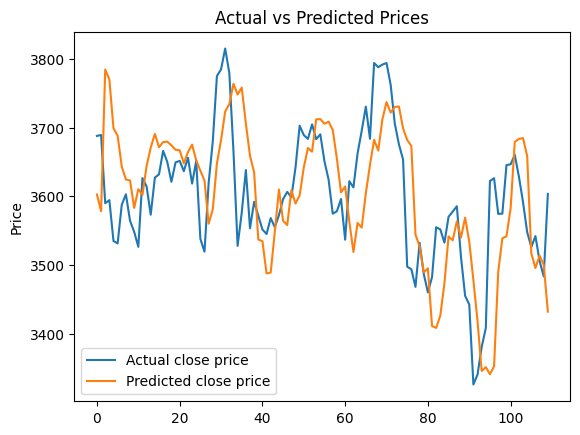

In [226]:
plt.plot(target_scaler.inverse_transform(test_targets.reshape(-1,1)), label='Actual close price')
plt.plot(np.array(pred_new).reshape(-1,1), label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

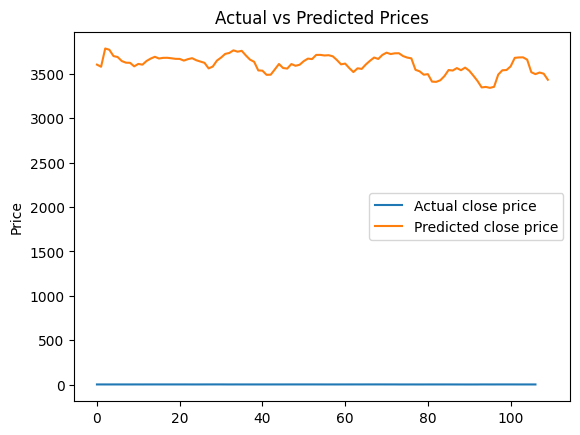

In [414]:
plt.plot(test_targets, label='Actual close price')
plt.plot(pred_new, label='Predicted close price')

plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()

plt.show()

In [ ]:
################

In [61]:
def convert_to_timesteps(array, timesteps=100):
    samples, features = array.shape
    output = np.zeros((samples, timesteps, features))

    for i in range(samples):
        start_idx = max(0, i - timesteps + 1)
        end_idx = i + 1
        window = array[start_idx:end_idx]
        output[i, -len(window):] = window

    return output



In [62]:
timesteps=100
X_train = convert_to_timesteps(X_train_scaled, timesteps=timesteps)
print(X_train.shape)

X_val = convert_to_timesteps(X_val_scaled, timesteps=timesteps)
X_val.shape

(973, 100, 10)


(215, 100, 10)

In [63]:
y_train = target_scaler.fit_transform(df_train["Next_Close"].values.reshape(-1, 1))
y_val=target_scaler.fit_transform(df_val["Next_Close"].values.reshape(-1, 1))

In [64]:

#timesteps = 1 
#X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], timesteps, X_train_scaled.shape[1]))
#X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], timesteps, X_test_scaled.shape[1]))

In [65]:
X_train.shape

(973, 100, 10)

Filter Value is :: 128


C:\Users\Divay Nagpal\anaconda3\envs\python310new1\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │         6,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6144)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,528 (25.50 KB)

 Trainable params: 6,528 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
mse :  4983599.881400151


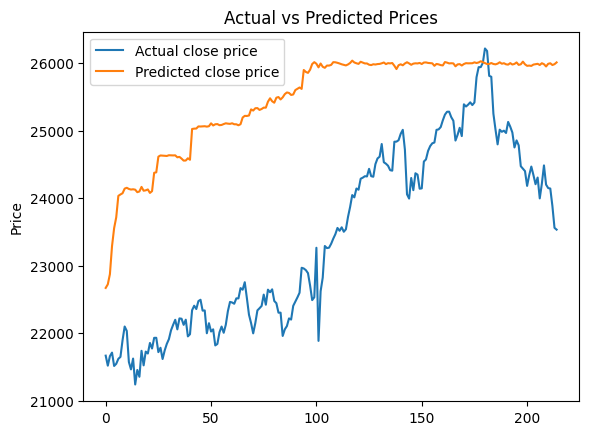

In [66]:
filter_vals=[128]
# For 1 layer
for filter_val in filter_vals:
    print("Filter Value is ::", filter_val)
    cnn_model = models.Sequential([
    Conv1D(filters=filter_val, kernel_size = 5, activation = 'relu', input_shape = (timesteps, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    ])
    cnn_model.summary()
    cnn_features = cnn_model.predict(X_train)
    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    xgb_model.fit(cnn_features, y_train)
    predictions = xgb_model.predict(cnn_model.predict(X_val))
    mse = mean_squared_error(target_scaler.inverse_transform(y_val), target_scaler.inverse_transform(predictions.reshape(-1,1)))
    print("mse : ",mse)
    
    plt.plot(target_scaler.inverse_transform(y_val), label='Actual close price')
    plt.plot(target_scaler.inverse_transform(predictions.reshape(-1,1)), label='Predicted close price')
    
    plt.title('Actual vs Predicted Prices')
    plt.ylabel('Price')
    plt.legend()
    
    plt.show()